# Demo for Hybrid Payoff Bandits

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from algorithms import HyLinUCB, DisLinUCB, LinUCBClassic, HyLinUCBv2
from environment import HybridBandits

In [22]:
# Define Environment Configuration

config = {}
config['seed'] = np.random.randint(1098321)
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 50000        # Number of time steps T
config['num_labels'] = 20               # Number of actions L
config['num_context'] = 10              # Context set size
config['theta_dim'] = 5                 # Dimension of theta d
config['beta_dim'] = 5                  # Dimension of beta k
config['theta_norm'] = 0.5              # Max norm of theta M
config['beta_norm'] = 0.5               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['is_easy'] = True               # Flag for whether the instance is easy (large suboptimality gap)
env_name = 'Testbench'                  # Name of the simulation

Seed: 790290


In [23]:
env = HybridBandits(env_name, config)

In [6]:
# Function to run 1 trial
def simulate(env, algo_arr, T):
    for _ in tqdm(range(T)):
        a_t = []
        for algo in algo_arr:
            a_t.append(algo.next_action())
        rewards_t, regrets_t, action_set_t = env.step(a_t)
        for i, algo in enumerate(algo_arr):
            algo.update(rewards_t[i], regrets_t[i], action_set_t)

In [7]:
def create_reward_plot(env:HybridBandits, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    x, y = 0, 0
    base = np.arange(1, env.L + 1)
    theta = env.parameters['theta']
    beta_arr = env.parameters['beta']
    for i in range(env.num_context):
        x = x % nrows
        y = y % ncols
        reward_arr = []
        for j, (a,b) in enumerate(env.arms[i]):
            reward_arr.append(np.dot(theta, a) + np.dot(beta_arr[j], b))
        ax[x][y].bar(base, reward_arr)
        ax[x][y].grid()
        x += 1
        y += 1
    plt.show()

In [8]:
def plot_regret(result_dict, T):
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    x = np.arange(1, T+1)
    for k in result_dict.keys():
        ax[0][0].plot(x, result_dict[k]['mean_reward'], label=k)
        min_reward = np.array(result_dict[k]['mean_reward']) - np.array(result_dict[k]['std_reward'])
        max_reward = np.array(result_dict[k]['mean_reward']) + np.array(result_dict[k]['std_reward'])
        ax[0][0].fill_between(x, min_reward, max_reward, alpha=0.2)

        ax[0][1].plot(x, result_dict[k]['mean_regret'], label=k)
        min_regret = np.array(result_dict[k]['mean_regret']) - np.array(result_dict[k]['std_regret'])
        max_regret = np.array(result_dict[k]['mean_regret']) + np.array(result_dict[k]['std_regret'])
        ax[0][1].fill_between(x, min_regret, max_regret, alpha=0.2)

        ax[1][0].plot(x, result_dict[k]['time_avg_reward'], label=k)
        ax[1][1].plot(x, result_dict[k]['time_avg_regret'], label=k)

    for i in range(2):
        for j in range(2):
            ax[i][j].set_xlabel('Time Steps')
            ax[i][j].grid()
            ax[i][j].legend()
    
    ax[0][0].set_ylabel('Cumulative Reward')
    ax[0][1].set_ylabel('Cumulative Regret')
    ax[1][0].set_ylabel('Time Avg Reward')
    ax[1][1].set_ylabel('Time Avg Regret')
    
    plt.show()

In [14]:
# Add the algorithms to test and their hyperparameters
algo_dict = {'HyLinUCB': {'lambda': 0.001, 'gamma': 0.001}, 
             'LinUCBClassic': {'alpha': 0.01},
             'DisLinUCB': {'lambda': 0.001}}
delta = 0.01 # High probability guarantee

In [24]:
# Code to run multiple trials

num_trials = 1  # Number of trials
T = env.T
all_rewards = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
all_regrets = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]

for i in range(num_trials):
    algo_arr = []
    for k in algo_dict.keys():
        if k == 'HyLinUCB':
            lmbda = algo_dict[k]['lambda']
            gamma = algo_dict[k]['gamma']
            algo_arr.append(HyLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, gamma))
        elif k == 'DisLinUCB':
            lmbda = algo_dict[k]['lambda']
            algo_arr.append(DisLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda))
        elif k == 'LinUCBClassic':
            alpha = algo_dict[k]['alpha']
            algo_arr.append(LinUCBClassic(env.get_first_action_set(), env.M, env.N, env.S1, env.S2, alpha))
        elif k == 'HyLinUCBv2':
            lmbda = algo_dict[k]['lambda']
            gamma = algo_dict[k]['gamma']
            algo_arr.append(HyLinUCBv2(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, gamma))
    print('Simulating Trial', i+1)
    simulate(env, algo_arr, T)
    env.reset()
    for j in range(len(algo_arr)):
        all_rewards[j][i] += np.array(algo_arr[j].rewards)
        all_regrets[j][i] += np.array(algo_arr[j].regrets)

Simulating Trial 1


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [03:53<00:00, 214.24it/s]


In [25]:
# Store results

result_dict = {}
for i, algo in enumerate(algo_dict.keys()):
    mean_reward = np.mean(all_rewards[i], axis=0)
    std_reward = np.std(all_rewards[i], axis=0)
    mean_regret = np.mean(all_regrets[i], axis=0)
    std_regret = np.std(all_regrets[i], axis=0)
    rewards = np.cumsum(mean_reward)
    regrets = np.cumsum(mean_regret)
    time_avg_rewards = rewards / np.arange(1, T+1)
    time_avg_regrets = regrets / np.arange(1, T+1)
    results = {'mean_reward': rewards, 'mean_regret': regrets, 'std_reward': std_reward,\
            'std_regret': std_regret,\
            'time_avg_reward': time_avg_rewards, 'time_avg_regret': time_avg_regrets}
    result_dict[algo] = results

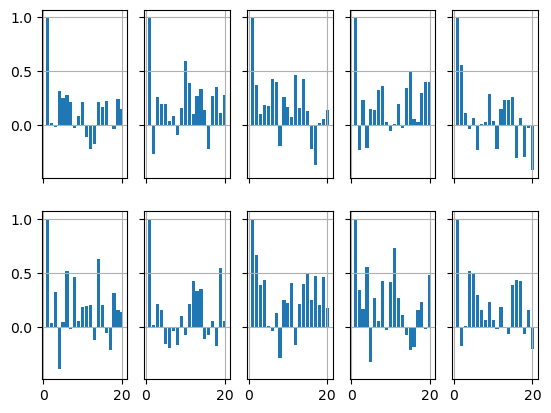

In [26]:
nrows = env.num_context // 5
create_reward_plot(env, nrows, 5)

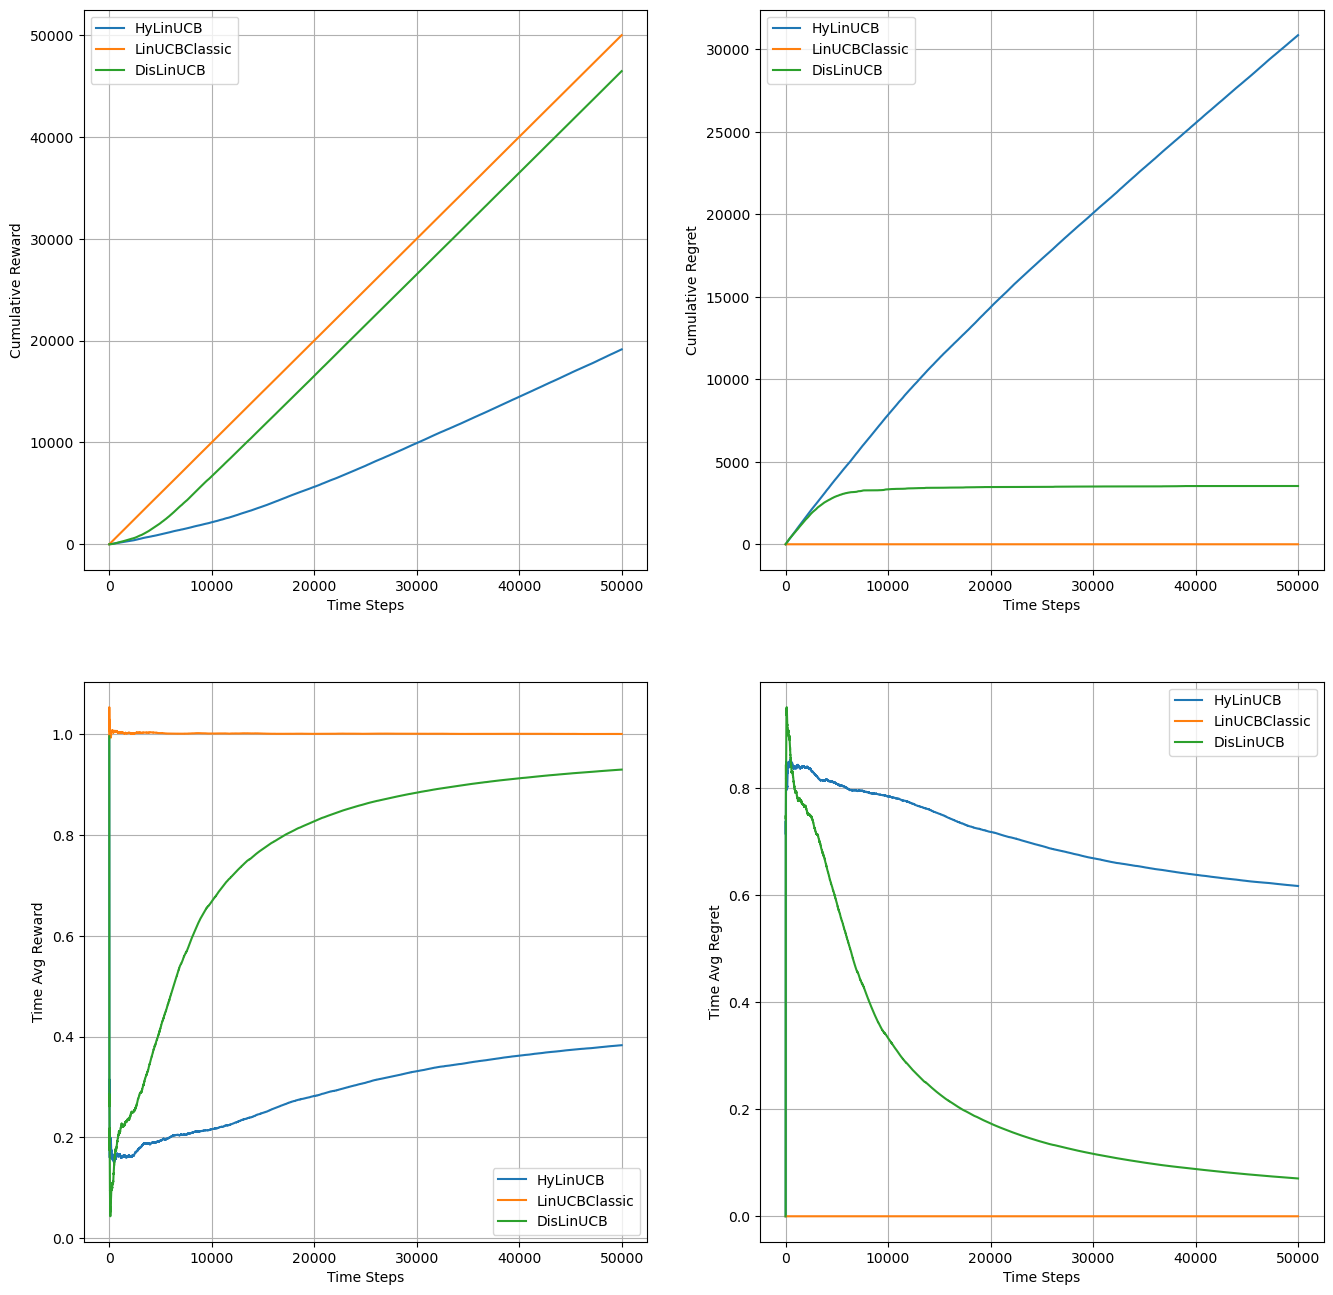

In [27]:
plot_regret(result_dict, env.T)